In [1]:
import numpy as np
import pandas as pd #for loading csv Excel files
import itertools #to merge lists
from scipy.interpolate import interp1d
from scipy.optimize import leastsq, curve_fit #for fitting
import matplotlib.pyplot as pl #for plots
from matplotlib import rc, rcParams
from scipy.special import kn #Modified Bessel function of the second kind of integer order n
from scipy.special import lambertw as prodlog 
import scipy.integrate as integrate #for (numerical) integrating
from scipy import optimize as opt #for numerical root finding
from scipy.special import erf
from matplotlib.lines import Line2D

In [7]:
fontsize=26
legendfontsize=22
font = {'size' : fontsize}
rc('font',**font)
rc('text', usetex=True)
rc('font', family='serif', serif='Computer Modern Roman')
#Color palette accessible to colorblind people (see https://davidmathlogic.com/colorblind/)
lightblue='#1A85FF'
blue='#005AB5'
darkblue='#222255'
purple='#5D3A9B'
magenta='#AA4499'
red='#DC3220'
orange='#E66100'
yellow='#FFC20A'
green='#40B0A6'

colors=[lightblue,blue,darkblue,purple,magenta,red,orange,yellow,green]

goldenratio=1.61803398875 #Standard Python ratio for plot width/height=8/6.

## Constants

In [3]:
hbar=1.
c=2.99792458*10.**8.*10.**(-3.) #km/s (not m/s)
GeV_to_cmminus1=5.068*10.**13.
GeV_to_g=1.78*10.**(-24.)
fm_to_cm=10.**(-15.)*10.**2.
gammaE=0.5772156649015328606065120900824024310421 #Euler Mascheroni constant

## Potential

In [5]:
#_____Yukawa potential_____
def U(potential,alphaX,mphi,r):
    if potential=='attractive':
        prefactor=-1.
    elif potential=='repulsive':
        prefactor=+1.
    #U=prefactor*hbar*c*(alphaX/r)*np.exp(-(c/hbar)*mphi*r)
    U=prefactor*(alphaX/r)*np.exp(-mphi*r)
    return U

## Numerical solution for $r_0$

beta=1000
l=100.0
[r0appr,r0num, Ueff(r0)]=[20.0, array(0.0200401), -0.00500284880399704]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


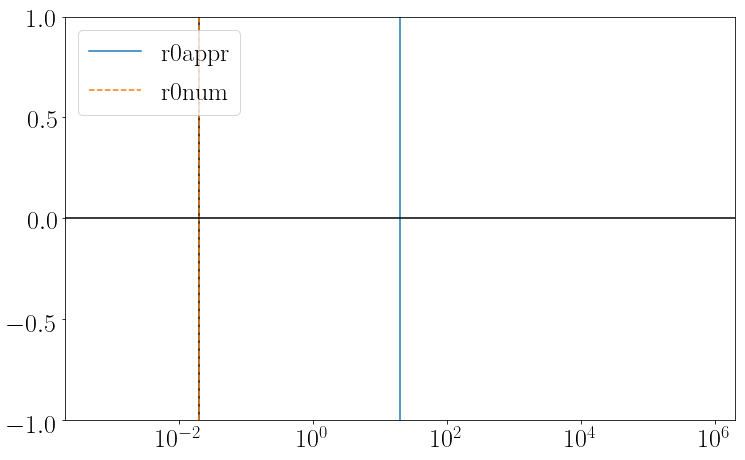

0.02004010027140957


In [8]:
def r0num(potential,alphaX,mX,mphi,l,v,logging=False):
    #_____Relations_____
    m=(mX/2.)  #reduced mass m
    p=m*(v/c) #momentum p
    k=p/hbar
    #_____r0_____
    def r0(r):
        #return k**2.-l**2/r**2.+2*m*U(potential,alphaX,mphi,r)
        #print('[term1,term2]='+str([-l**2/r**2.,2*m*U(potential,alphaX,mphi,r)]))
        return (-1.)*(k**2.-l**2/r**2.-2*m*U(potential,alphaX,mphi,r)) 
    r0appr=l/k
    #[r0min,r0max]=[10.**(-5.)*r0appr,10.**(5.)*r0appr]
    #[r0min,r0max]=[10.**(-5.)*r0appr,r0appr]
    #r0num=opt.brentq(r0,r0min,r0max,maxiter=500) #Numerically unstable
    r0vals=np.logspace(np.log10(10.**(-5.)*r0appr),np.log10(10.**5.*r0appr),1000)
    r0index=list(itertools.chain.from_iterable(np.argwhere(r0(r0vals)>0)))[-1] #Find outermost solution
    #print(r0vals[r0index])
    #epsilon=10.**(-1.)
    epsilon=0.1
    [r0min,r0max]=[(1-epsilon)*r0vals[r0index],(1+epsilon)*r0vals[r0index]]
    r0valsnew=np.logspace(np.log10(r0min),np.log10(r0max),10000)
    r_r0Int=interp1d(r0(r0valsnew),r0valsnew,kind='linear')
    r0num=r_r0Int(0.)
    #print(r0num)
    if logging==True:
        print('[r0appr,r0num, Ueff(r0)]='+str([r0appr,r0num, r0(r0num)]))
        #print(l**2/(mX*(v/(2*c*mphi)))**2*1/(4*alphaX*mphi/(mX*(v/c)**2)))
        pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
        #r0vals=np.logspace(np.log10(10.**(-5.)*r0appr),np.log10(10.**5.*r0appr),100)
        pl.plot(r0vals,r0(r0vals),color='black')
        #for r in r0vals:
        #    print([r,r0(r)])
        pl.axvline(r0appr,color='C0',label='r0appr')
        pl.axvline(r0num,color='C1',label='r0num',linestyle='--')
        #pl.axvline(l**2/(mX*(v/(2*c*mphi)))**2*1/(4*alphaX*mphi/(mX*(v/c)**2)), color='red', linestyle='-', label='appr 2')
        #pl.axvline((mX*alphaX - np.sqrt(mX**2*alphaX**2 + 4*k**2))/(2*k**2), color='red', label='r0appr2', linestyle=':')
        #pl.axvline(r0min,color='black',linestyle=':')
        #pl.axvline(r0max,color='black',linestyle=':')
        pl.axhline(0.,color='black')
        pl.legend(loc='upper left')
        pl.xscale('log')
        #pl.yscale('log')
        pl.xlim([r0vals[0],r0vals[-1]])
        pl.ylim([-1.,1.])
        #pl.ylim([-10000.,10000.])
        pl.show()
    return r0num

for beta in [1000]:
    print('beta='+str(beta))
    #for l in [1,8,30,500]:
    for l in [100.]:
        print('l='+str(l))
        #_____Fixed parameters_____
        potential='attractive'
        alphaX=0.1
        mphi=0.1 #GeV.
        #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
        cl = 100
        mX= cl**2*beta/2
        #print(mX)
        v=(0.2/(beta*cl))*c #km/s
        #print(v)
        print(r0num(potential,alphaX,mX,mphi,l,v,logging=True))

## Numerical solution for $\delta_l$

In [13]:
def deltalr0num(potential,alphaX,mX,mphi,l,v):
    #_____Relations_____
    m=(mX/2.)  #reduced mass m
    p=m*(v/c) #momentum p
    k=p/hbar
    #E=(hbar**2.*k**2.)/(2.*m) #kinetic energy
    E=p**2./(2.*m) #kinetic energy
    #_____deltal integral_____
    #def integrand(r):
    #    return -(mX/hbar**2)*(U(potential,alphaX,mphi,r)/np.sqrt(k**2.-((l+1./2.)**2./r**2.)))
    #def integrand(r):
    #    return (1./hbar)*np.sqrt(hbar**2.*k**2.-2.*m*U(potential,alphaX,mphi,r)-(hbar**2.*(l+1./2.)**2.)/r**2.)-k ###Doesn't work well. Numerically very unstable.
    def integrand(r):
        x=1.-(r0**2./r**2)
        #x=k**2.-((l+1./2.)**2./r**2.)
        y=U(potential,alphaX,mphi,r)/(E*c**2)
        #y=2*m*U(potential,alphaX,mphi,r)
        #print([x,y])
        #print([np.sqrt(x-y),np.sqrt(x)])
        #return np.sqrt(x-y)-np.sqrt(x)
        #print([np.sqrt(1-y/x),1.])
        return np.sqrt(x)*(np.sqrt(1-y/x)-1.)
    #r0=l/k
    r0=r0num(potential,alphaX,mX,mphi,l,v)
    #rmax=10**6 #.*r0 #Value cannot be smaller than this for l=1. Otherwise r0>rmax.
    rmax=10**2.*r0 #Value cannot be smaller than this for l=1. Otherwise r0>rmax.
#     #rmax=10.**10.
#     #print([r0,rmax])
#     epsilon=10.**(-8.)
#     rvals=np.logspace(np.log10((1+epsilon)*r0),np.log10(rmax),5000.)
#     integrandvals=np.array([integrand(r) for r in rvals])
#     #print(integrandvals)
#     deltalintegral=np.trapz(integrandvals,x=rvals) #Trapezoidal rule is slower and less accurate.
    logging=False
    if logging:
        print([r0,rmax,rmax/r0])
        pl.xscale('log')
        #pl.yscale('log') 
        Rvals=np.logspace(np.log10(r0),np.log10(rmax),50)
        pl.plot(Rvals,[integrand(r) for r in Rvals])
        pl.show()
        pl.xscale('log')
        #pl.yscale('log')
        pl.plot(Rvals,[U(potential,alphaX,mphi,r) for r in Rvals])
        pl.show()
    #deltal=integrate.quad(integrand,r0,rmax,limit=200)[0] #,limit=200
    #deltalintegral=integrate.quad(integrand,r0,rmax,limit=500,points=r0)[0] #,limit=200
    #deltal=deltalintegral+(1./2.)*np.pi*(l+(1./2.))-k*r0
    #print([deltalintegral,(1./2.)*np.pi*(l+(1./2.))-k*r0])
    #deltalintegral=integrate.quad(integrand,r0,rmax,limit=500,epsabs=5.*10.**(-7.), epsrel=5*10.**(-1.))[0]
    deltalintegral=integrate.quad(integrand,r0,rmax)[0]
    deltal=k*c**2*deltalintegral
    if deltal == 0:
        deltal = 0#deltalappr(potential,alphaX,mX,mphi,l,v)
    return deltal

potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
l=1.
v=10. #km/s

print(deltalr0num(potential,alphaX,mX,mphi,l,v))

def deltalr0num_beta(l,beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    return deltalr0num(potential,alphaX,mX,mphi,l,v)
    
for beta in [1000.]:
    for l in [2]:
        for cl in [10.]:
            print(deltalr0num_beta(l,beta, cl))

1573.5584834851848
26442.901292817984


## $\delta_{l+1} - \delta_l$

In [17]:
def diffdeltaldlr0num(potential,alphaX,mX,mphi,lvals,v):
    #_____deltal_____
    def deltal_l(l):
        return deltalr0num(potential,alphaX,mX,mphi,l,v)
    #_____d deltal/dl_____
    diffdeltalvals=np.array([deltal_l(l+1)-deltal_l(l) for l in lvals])
    ldiffdeltaldlvals=np.array([[lvals[i],diffdeltalvals[i]] for i in range(0,len(lvals))])
    return ldiffdeltaldlvals

potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
#l=1.
v=10. #km/s
lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
#print(lvalsnew)
#print(ddeltaldlr0num(potential,alphaX,mX,mphi,lvalsnew,v))

def diffdeltaldlr0num_beta(lvals,beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    return diffdeltaldlr0num(potential,alphaX,mX,mphi,lvals,v)
    
for beta in [1.,10.,100.,1000.]:
    for lvals in [lvalsnew]:
        for cl in [10.]:
            print(diffdeltaldlr0num_beta(lvals,beta, cl))

[[ 1.00000000e+00 -6.76237643e+00]
 [ 2.00000000e+00 -4.09673734e+00]
 [ 3.00000000e+00 -2.78979778e+00]
 [ 4.00000000e+00 -1.90130575e+00]
 [ 5.00000000e+00 -1.22077150e+00]
 [ 6.00000000e+00 -7.53034700e-01]
 [ 7.00000000e+00 -4.70113852e-01]
 [ 8.00000000e+00 -3.04852329e-01]
 [ 9.00000000e+00 -2.05219385e-01]
 [ 1.00000000e+01 -1.43099778e-01]
 [ 1.10000000e+01 -1.02040044e-01]
 [ 1.20000000e+01 -7.45864260e-02]
 [ 1.30000000e+01 -5.52224014e-02]
 [ 1.40000000e+01 -4.13709389e-02]
 [ 1.50000000e+01 -3.15745188e-02]
 [ 1.60000000e+01 -2.42202363e-02]
 [ 1.70000000e+01 -1.83015257e-02]
 [ 1.80000000e+01 -1.44838823e-02]
 [ 1.90000000e+01 -1.11106452e-02]
 [ 2.00000000e+01 -8.57618030e-03]
 [ 2.10000000e+01 -6.88755641e-03]
 [ 2.20000000e+01 -5.49969491e-03]
 [ 2.30000000e+01 -4.05121308e-03]
 [ 2.40000000e+01 -3.60998896e-03]
 [ 2.50000000e+01 -2.39099741e-03]
 [ 2.60000000e+01 -2.22403334e-03]
 [ 2.70000000e+01 -1.50647856e-03]
 [ 2.80000000e+01 -1.57472092e-03]
 [ 2.90000000e+01 -1

[[ 1.00000000e+00 -3.01080120e+01]
 [ 2.00000000e+00 -4.68720041e+01]
 [ 3.00000000e+00 -6.73325656e+01]
 [ 4.00000000e+00 -8.70979632e+01]
 [ 5.00000000e+00 -1.06093944e+02]
 [ 6.00000000e+00 -1.24332550e+02]
 [ 7.00000000e+00 -1.41793611e+02]
 [ 8.00000000e+00 -1.58434325e+02]
 [ 9.00000000e+00 -1.74203379e+02]
 [ 1.00000000e+01 -1.89049848e+02]
 [ 1.10000000e+01 -2.02927882e+02]
 [ 1.20000000e+01 -2.15799134e+02]
 [ 1.30000000e+01 -2.27634731e+02]
 [ 1.40000000e+01 -2.38414904e+02]
 [ 1.50000000e+01 -2.48130044e+02]
 [ 1.60000000e+01 -2.56780132e+02]
 [ 1.70000000e+01 -2.64374458e+02]
 [ 1.80000000e+01 -2.70931165e+02]
 [ 1.90000000e+01 -2.76476335e+02]
 [ 2.00000000e+01 -2.81043507e+02]
 [ 2.10000000e+01 -2.84672758e+02]
 [ 2.20000000e+01 -2.87409264e+02]
 [ 2.30000000e+01 -2.89303331e+02]
 [ 2.40000000e+01 -2.90408769e+02]
 [ 2.50000000e+01 -2.90782012e+02]
 [ 2.60000000e+01 -2.90480992e+02]
 [ 2.70000000e+01 -2.89565787e+02]
 [ 2.80000000e+01 -2.88095137e+02]
 [ 2.90000000e+01 -2

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


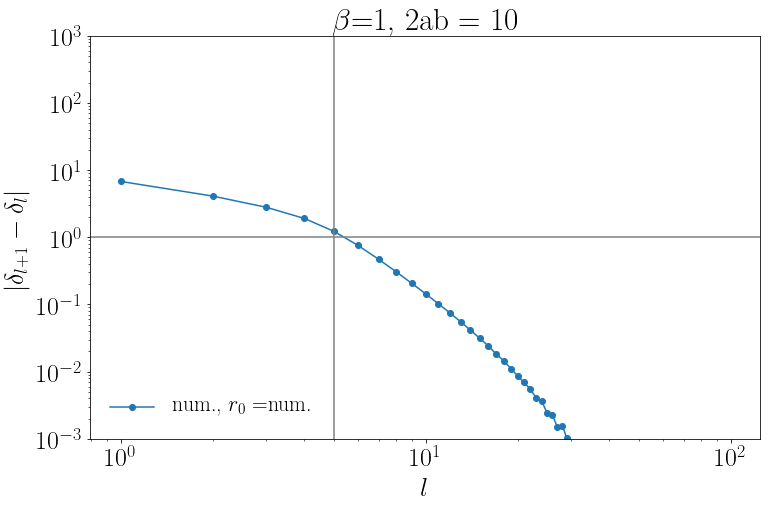

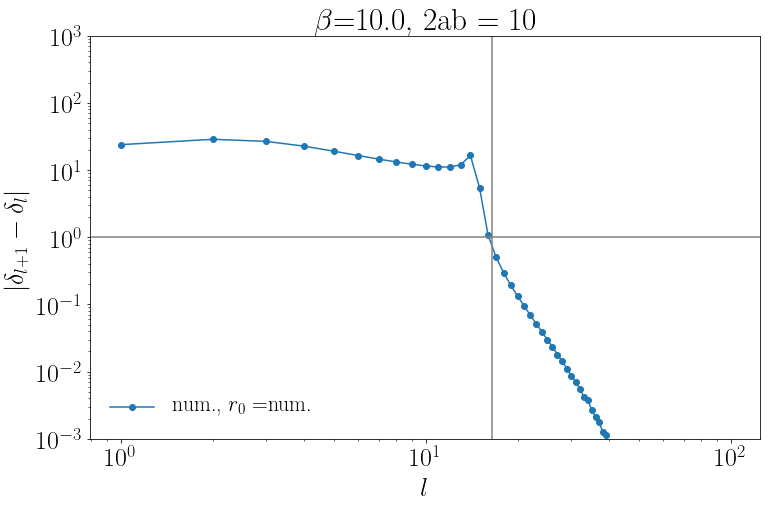

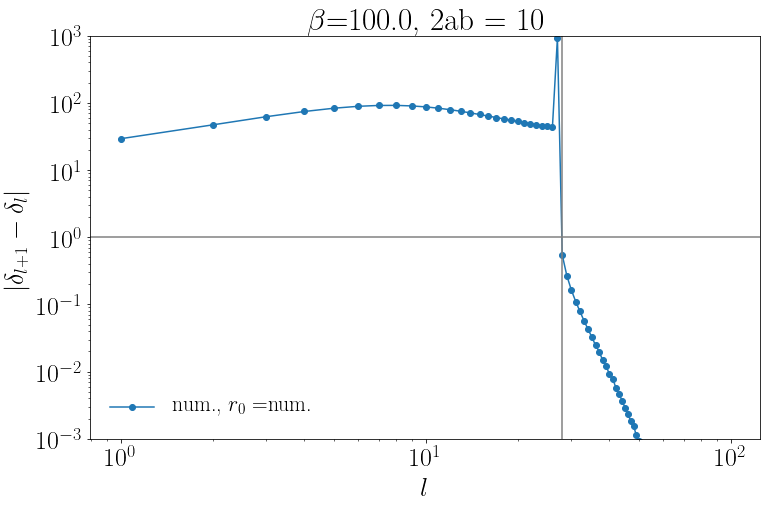

In [19]:
lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
#lvalsnew=np.logspace(np.log10(1),np.log10(100),500) #l=1,2,...,1500
#print(lvalsnew)
cl = 10

for beta in [1,10.,100.]:
#for beta in [1000.]:
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    
    diffdeltaldlr0num_betavals=diffdeltaldlr0num_beta(lvalsnew,beta, cl)
    #print(ddeltaldlr0num_betavals)
    pl.plot(diffdeltaldlr0num_betavals[:,0],abs(diffdeltaldlr0num_betavals[:,1]),'o-',color='C0',label='num., $r_0=$num.')
    
    
    pl.xscale('log')
    pl.yscale('log')
    pl.ylim([10.**(-3.),10.**3.])
    pl.xlabel(r'$l$',fontsize=fontsize)
    pl.axhline(1,color = 'grey')
    pl.axvline(cl/2*(1+np.log(beta)), color='grey')
    #pl.ylabel(r'$\Delta (\delta_{l+1}-\delta_{l})$',fontsize=fontsize) 
    pl.ylabel(r'$|\delta_{l+1} - \delta_l |$',fontsize=fontsize) 
    pl.legend(loc='lower left',edgecolor='white',fontsize=legendfontsize) 
    pl.title(r'$\beta$='+str(beta) + ', 2ab = '+str(cl))
    #pl.savefig('Plots/ddeltal_dl_beta'+str(beta)+'.pdf',bbox_inches='tight')
    #print('PPlots/ddeltal_dl_beta'+str(beta)+'.pdf exported.')
    pl.show()

## Numerical $d\delta_l/dl$

In [14]:
def ddeltaldlr0num(potential,alphaX,mX,mphi,lvals,v):
    #_____deltal_____
    def deltal_l(l):
        return deltalr0num(potential,alphaX,mX,mphi,l,v)
    #_____d deltal/dl_____
    deltalvals=np.array([deltal_l(l) for l in lvals])
    ddeltaldlvals=np.gradient(deltalvals,lvals)
    lddeltaldlvals=np.array([[lvals[i],ddeltaldlvals[i]] for i in range(0,len(lvals))])
    return lddeltaldlvals

potential='attractive' #['attractive','repulsive']:
alphaX=10.**(-2.)
mX=200 #GeV
mphi=10**(-3.) #GeV.
#l=1.
v=10. #km/s
lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
#print(lvalsnew)
#print(ddeltaldlr0num(potential,alphaX,mX,mphi,lvalsnew,v))

def ddeltaldlr0num_beta(lvals,beta, cl):
    #_____Fixed parameters_____
    potential='attractive'
    alphaX=0.1
    mphi=0.1 #GeV.
    #_____Parameters chosen such that 2ab=10 (classical regime 2ab>>1)_____
    mX= cl**2*beta/2
    #print(mX)
    v=0.2/(beta*cl)*c #km/s
    #print(v)
    return ddeltaldlr0num(potential,alphaX,mX,mphi,lvals,v)
    
for beta in [1.,10.,100.,1000.]:
    for lvals in [lvalsnew]:
        for cl in [10.]:
            print(ddeltaldlr0num_beta(lvals,beta, cl))

[[ 1.00000000e+00 -6.76237643e+00]
 [ 2.00000000e+00 -5.42955688e+00]
 [ 3.00000000e+00 -3.44326756e+00]
 [ 4.00000000e+00 -2.34555176e+00]
 [ 5.00000000e+00 -1.56103862e+00]
 [ 6.00000000e+00 -9.86903099e-01]
 [ 7.00000000e+00 -6.11574276e-01]
 [ 8.00000000e+00 -3.87483091e-01]
 [ 9.00000000e+00 -2.55035857e-01]
 [ 1.00000000e+01 -1.74159582e-01]
 [ 1.10000000e+01 -1.22569911e-01]
 [ 1.20000000e+01 -8.83132352e-02]
 [ 1.30000000e+01 -6.49044137e-02]
 [ 1.40000000e+01 -4.82966701e-02]
 [ 1.50000000e+01 -3.64727288e-02]
 [ 1.60000000e+01 -2.78973776e-02]
 [ 1.70000000e+01 -2.12608810e-02]
 [ 1.80000000e+01 -1.63927040e-02]
 [ 1.90000000e+01 -1.27972637e-02]
 [ 2.00000000e+01 -9.84341275e-03]
 [ 2.10000000e+01 -7.73186835e-03]
 [ 2.20000000e+01 -6.19362566e-03]
 [ 2.30000000e+01 -4.77545399e-03]
 [ 2.40000000e+01 -3.83060102e-03]
 [ 2.50000000e+01 -3.00049318e-03]
 [ 2.60000000e+01 -2.30751537e-03]
 [ 2.70000000e+01 -1.86525595e-03]
 [ 2.80000000e+01 -1.54059974e-03]
 [ 2.90000000e+01 -1

[[ 1.00000000e+00 -3.01080120e+01]
 [ 2.00000000e+00 -3.84900081e+01]
 [ 3.00000000e+00 -5.71022849e+01]
 [ 4.00000000e+00 -7.72152644e+01]
 [ 5.00000000e+00 -9.65959535e+01]
 [ 6.00000000e+00 -1.15213247e+02]
 [ 7.00000000e+00 -1.33063081e+02]
 [ 8.00000000e+00 -1.50113968e+02]
 [ 9.00000000e+00 -1.66318852e+02]
 [ 1.00000000e+01 -1.81626613e+02]
 [ 1.10000000e+01 -1.95988865e+02]
 [ 1.20000000e+01 -2.09363508e+02]
 [ 1.30000000e+01 -2.21716933e+02]
 [ 1.40000000e+01 -2.33024818e+02]
 [ 1.50000000e+01 -2.43272474e+02]
 [ 1.60000000e+01 -2.52455088e+02]
 [ 1.70000000e+01 -2.60577295e+02]
 [ 1.80000000e+01 -2.67652811e+02]
 [ 1.90000000e+01 -2.73703750e+02]
 [ 2.00000000e+01 -2.78759921e+02]
 [ 2.10000000e+01 -2.82858133e+02]
 [ 2.20000000e+01 -2.86041011e+02]
 [ 2.30000000e+01 -2.88356298e+02]
 [ 2.40000000e+01 -2.89856050e+02]
 [ 2.50000000e+01 -2.90595390e+02]
 [ 2.60000000e+01 -2.90631502e+02]
 [ 2.70000000e+01 -2.90023390e+02]
 [ 2.80000000e+01 -2.88830462e+02]
 [ 2.90000000e+01 -2

## Plots

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


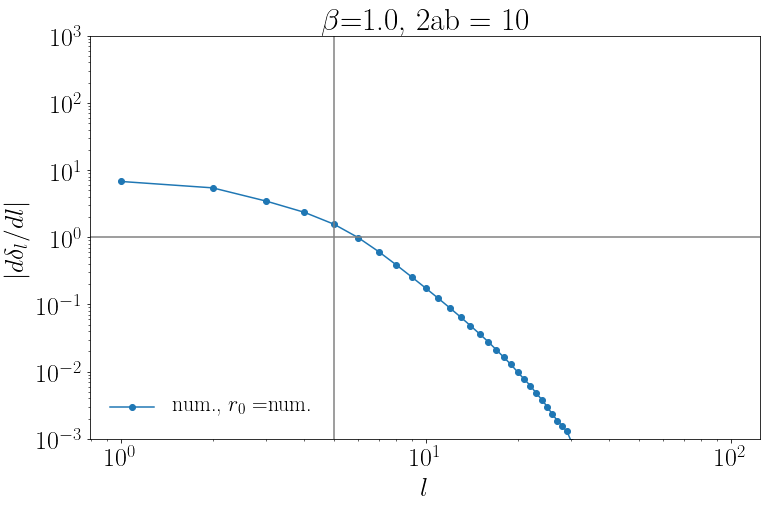

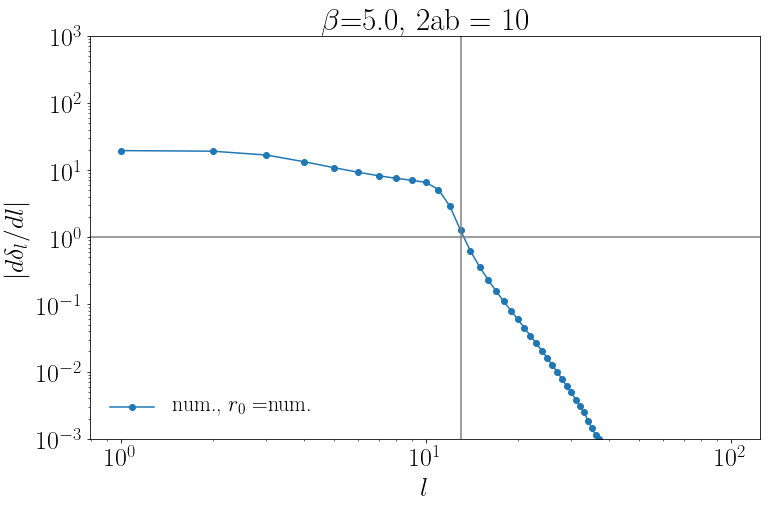

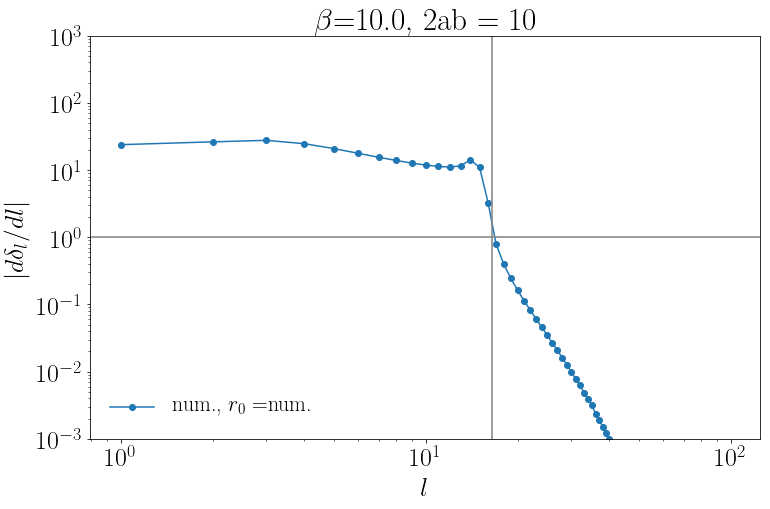

In [15]:
lvalsnew=np.array([l for l in range(1,100)]) #l=1,2,...,1500
#lvalsnew=np.logspace(np.log10(1),np.log10(100),500) #l=1,2,...,1500
#print(lvalsnew)
cl = 10

for beta in [1.,5.,10.]:
#for beta in [1000.]:
    pl.figure(figsize=(12,12/goldenratio)) #Sophia's plot size.
    
    ddeltaldlr0num_betavals=ddeltaldlr0num_beta(lvalsnew,beta, cl)
    #print(ddeltaldlr0num_betavals)
    pl.plot(ddeltaldlr0num_betavals[:,0],abs(ddeltaldlr0num_betavals[:,1]),'o-',color='C0',label='num., $r_0=$num.')
    
    
    pl.xscale('log')
    pl.yscale('log')
    pl.ylim([10.**(-3.),10.**3.])
    pl.xlabel(r'$l$',fontsize=fontsize)
    pl.axhline(1,color = 'grey')
    pl.axvline(cl/2*(1+np.log(beta)), color='grey')
    #pl.ylabel(r'$\Delta (\delta_{l+1}-\delta_{l})$',fontsize=fontsize) 
    pl.ylabel(r'$| d \delta_{l} / d l |$',fontsize=fontsize) 
    pl.legend(loc='lower left',edgecolor='white',fontsize=legendfontsize) 
    pl.title(r'$\beta$='+str(beta) + ', 2ab = '+str(cl))
    #pl.savefig('Plots/ddeltal_dl_beta'+str(beta)+'.pdf',bbox_inches='tight')
    #print('PPlots/ddeltal_dl_beta'+str(beta)+'.pdf exported.')
    pl.show()